In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

import pandas as pd

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from HFC125_emimTf2N_PR import configuration
data = pd.read_csv('R125_emimTf2N.csv')

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}
print(data)

    temperature  pressure  x_R125  x_emimTf2N
0         283.1     10000   0.008       0.992
1         283.1    100000   0.085       0.915
2         283.1    199700   0.168       0.832
3         283.1    297700   0.250       0.750
4         283.1    399700   0.331       0.669
5         283.1    499900   0.413       0.587
6         283.1    599700   0.496       0.504
7         283.1    699900   0.583       0.417
8         283.1    799600   0.681       0.319
9         298.1     10200   0.006       0.994
10        298.1     99800   0.055       0.945
11        298.1    199700   0.109       0.891
12        298.1    299700   0.161       0.839
13        298.2    399600   0.213       0.787
14        298.2    499900   0.267       0.733
15        298.2    599700   0.317       0.683
16        298.1    800100   0.422       0.578
17        298.1    999800   0.521       0.479
18        323.1     10200   0.004       0.996
19        323.1     99800   0.030       0.970
20        323.1    200000   0.059 

In [3]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(0.5)

m.fs.properties.PR_kappa_A['emimTf2N', 'R125'].fix(-0.00822)
m.fs.properties.PR_kappa_A['R125', 'emimTf2N'].fix(-0.01088)
m.fs.properties.PR_kappa_B['emimTf2N', 'R125'].fix(0.0)
m.fs.properties.PR_kappa_B['R125', 'emimTf2N'].fix(0.0)

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

In [4]:
print(data)

    temperature  pressure  x_R125  x_emimTf2N
0         283.1     10000   0.008       0.992
1         283.1    100000   0.085       0.915
2         283.1    199700   0.168       0.832
3         283.1    297700   0.250       0.750
4         283.1    399700   0.331       0.669
5         283.1    499900   0.413       0.587
6         283.1    599700   0.496       0.504
7         283.1    699900   0.583       0.417
8         283.1    799600   0.681       0.319
9         298.1     10200   0.006       0.994
10        298.1     99800   0.055       0.945
11        298.1    199700   0.109       0.891
12        298.1    299700   0.161       0.839
13        298.2    399600   0.213       0.787
14        298.2    499900   0.267       0.733
15        298.2    599700   0.317       0.683
16        298.1    800100   0.422       0.578
17        298.1    999800   0.521       0.479
18        323.1     10200   0.004       0.996
19        323.1     99800   0.030       0.970
20        323.1    200000   0.059 

In [5]:
bmim = np.linspace(data["x_emimTf2N"].iloc[8], data["x_emimTf2N"].iloc[0], 15)

P = np.zeros((len(bmim)))
P0 = np.zeros((len(bmim)))
R125_x1 = np.zeros((len(bmim)))
m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

for i in range(len(bmim)-1):
    print(i)
    m.fs.liq = bmim[i]
    a = bmim[i]
#     print(a)
    b = 1-(bmim[i])
#     print(b)
    P0[i] = -96365.23*b**2 + 1256050.41*b - 4800.10
#     print(P0)

    m.fs.F101.inlet.temperature.fix(283.001)
    m.fs.F101.inlet.pressure.fix(P0[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(1-(bmim[i]-0.05))
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(bmim[i]-0.05)
    m.fs.F101.vap_outlet.temperature.fix(283.001)
    m.fs.F101.vap_outlet.pressure.fix(P0[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R125_x1[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R125_x1[i] = "NaN"
            P[i] = "NaN"

bmim2 = np.linspace(data["x_emimTf2N"].iloc[17], data["x_emimTf2N"].iloc[9], 15)

P2 = np.zeros((len(bmim2)))
P02 = np.zeros((len(bmim2)))
R125_x2 = np.zeros((len(bmim2)))

for i in range(len(bmim2)-1):
    print(i)
    m.fs.liq = bmim2[i]
    a = bmim2[i]
    b = 1-(bmim2[i])
    P02[i] = 146087.64*b**2 + 1843871.31*b - 1502.18
#     print(P02)

    m.fs.F101.inlet.temperature.fix(298.001)
    m.fs.F101.inlet.pressure.fix(P02[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(1-(bmim2[i]-0.05))
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(bmim2[i]-0.05)
    m.fs.F101.vap_outlet.temperature.fix(298.001)
    m.fs.F101.vap_outlet.pressure.fix(P02[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R125_x2[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
            P2[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R125_x2[i] = "NaN"
            P2[i] = "NaN"
            
bmim3 = np.linspace(data["x_emimTf2N"].iloc[26], data["x_emimTf2N"].iloc[18], 15)

P3 = np.zeros((len(bmim3)))
P03 = np.zeros((len(bmim3)))
R125_x3 = np.zeros((len(bmim3)))

for i in range(len(bmim3)-1):
    print(i)
    m.fs.liq = bmim3[i]
    a = bmim3[i]
    b = 1-(bmim3[i])
    P03[i] = 3511704.55*b - 10059.05
    
#     print(P03)
    m.fs.F101.inlet.temperature.fix(323.001)
    m.fs.F101.inlet.pressure.fix(P03[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(1-(bmim3[i]-0.05))
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(bmim3[i]-0.05)
    m.fs.F101.vap_outlet.temperature.fix(323.001)
    m.fs.F101.vap_outlet.pressure.fix(P03[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R125_x3[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
            P3[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R125_x3[i] = "NaN"
            P3[i] = "NaN"
            
bmim4 = np.linspace(data["x_emimTf2N"].iloc[35], data["x_emimTf2N"].iloc[27], 15)

P4 = np.zeros((len(bmim4)))
P04 = np.zeros((len(bmim4)))
R125_x4 = np.zeros((len(bmim4)))

for i in range(len(bmim4)-1):
    print(i)
    m.fs.liq = bmim4[i]
    a = bmim4[i]
    b = 1-(bmim4[i])
    P04[i] = 5775793.74*b - 10436.12
#     print(P04)
    m.fs.F101.inlet.temperature.fix(348.001)
    m.fs.F101.inlet.pressure.fix(P04[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(1-(bmim4[i]-0.05))
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(bmim4[i]-0.05)
    m.fs.F101.vap_outlet.temperature.fix(348.001)
    m.fs.F101.vap_outlet.pressure.fix(P04[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R125_x4[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
            P4[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R125_x4[i] = "NaN"
            P4[i] = "NaN"

0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13


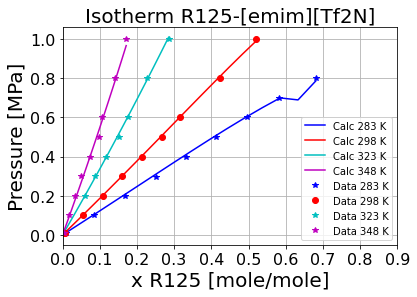

In [6]:
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

P22= np.zeros((len(P2)))

for i in range(len(P22)):
    P22[i] = P2[i]/1e6    
    
P32= np.zeros((len(P3)))

for i in range(len(P32)):
    P32[i] = P3[i]/1e6

P42= np.zeros((len(P4)))

for i in range(len(P42)):
    P42[i] = P4[i]/1e6
 
P1[1]=0.6888

plt.plot(R125_x1,P1,"b",label="Calc 283 K")  
plt.plot(R125_x2,P22,"r",label="Calc 298 K") 
plt.plot(R125_x3,P32,"c",label="Calc 323 K")
plt.plot(R125_x4,P42,"m",label="Calc 348 K")
plt.plot(data["x_R125"][0:9],data["pressure"][0:9]/1e6,"*",color='b',label="Data 283 K")  
plt.plot(data["x_R125"][9:19],data["pressure"][9:19]/1e6,"o",color='r',label="Data 298 K") 
plt.plot(data["x_R125"][20:27],data["pressure"][20:27]/1e6,"*",color='c',label="Data 323 K") 
plt.plot(data["x_R125"][27:],data["pressure"][27:]/1e6,"*",color='m',label="Data 348 K") 
plt.title('Isotherm R125-[emim][Tf2N]',fontsize=20)
plt.ylabel('Pressure [MPa]',fontsize=20)
plt.xlabel('x R125 [mole/mole]',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
# plt.ylim(0,1.110000)
plt.xlim(0,0.9)
plt.legend(fontsize=10)
# plt.savefig('Isotherm R125-[emim][Tf2N]_bin.png', bbox_inches='tight',dpi=300)
plt.show()


In [7]:
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value   : Fixed : Bounds
          Heat Duty : -7.4626 : False : (None, None)
    Pressure Change :  2565.2 : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                              Inlet   Vapor Outlet  Liquid Outlet
    flow_mol                  1.0000     0.050809      0.94919   
    mole_frac_comp emimTf2N  0.93407   1.0000e-08      0.98407   
    mole_frac_comp R125     0.065929       1.0000     0.015929   
    temperature               348.00       348.00       348.00   
    pressure                  81564.       84129.       84129.   


In [8]:
# print(P1)

In [9]:
df = pd.DataFrame(P)
# df.to_csv('P_cons_125.csv')
# df.to_csv('P_lin_125.csv')
# df.to_csv('P_ter_125.csv')

In [10]:
m.display()

Model unknown

  Variables:
    None

  Objectives:
    None

  Constraints:
    None

  Blocks:
    Block fs
    
      Variables:
        None
    
      Objectives:
        None
    
      Constraints:
        liquid : Size=1
            Key  : Lower              : Body               : Upper
            None : 0.9840714285714286 : 0.9840714285714286 : 0.9840714285714286
    
      Blocks:
        Block fs.properties
        
          Variables:
            PR_kappa_A : PRA binary interaction parameters
                Size=4, Index=fs.properties.PR_kappa_A_index
                Key                      : Lower : Value    : Upper : Fixed : Stale : Domain
                        ('R125', 'R125') :  None :      0.0 :  None :  True :  True :  Reals
                    ('R125', 'emimTf2N') :  None : -0.01088 :  None :  True :  True :  Reals
                    ('emimTf2N', 'R125') :  None : -0.00822 :  None :  True :  True :  Reals
                ('emimTf2N', 'emimTf2N') :  None :     

                    Key : Lower : Body                  : Upper
                    0.0 :   0.0 : 6.153002107822658e-08 :   0.0
                pressure_balance : Size=1
                    Key : Lower : Body                  : Upper
                    0.0 :   0.0 : 4.547473508864641e-13 :   0.0
            
              Blocks:
                Block fs.F101.control_volume.properties_in[0.0]
                
                  Variables:
                    flow_mol :  Total molar flowrate
                        Size=1, Index=None, Units=mol/s
                        Key  : Lower : Value : Upper : Fixed : Stale : Domain
                        None :     0 :     1 :  1000 :  True :  True : NonNegativeReals
                    mole_frac_comp : Mixture mole fractions
                        Size=2, Index=fs.properties.component_list
                        Key      : Lower : Value               : Upper : Fixed : Stale : Domain
                            R125 :     0 : 0.06592857142857